## 2-way `residalResponse` modified in covariance matrix.
All conditions for a single subject.

Modifying the residualResponse from the encoding-decoding model. Using $\Omega_1$ from van Bergen, Nat Neuro doi:10.1038/nn.4150

The parts where the code has changed are denoted by the marker: # CHANGE

### Created by Daniela del Rio on November, 2024

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time

from scipy.stats import multivariate_normal, pearsonr, ttest_ind, ttest_1samp, norm
from scipy.optimize import curve_fit

In [2]:
# # Function taken from: V2_piece_by_piece, 9/26/2024
# # Function that simulates BOLD response [B] with a gaussian function.
# def simulate_data(nStimuli = 9, nRepeats = 20, nNeurons=120, sigma=10, nVoxels=50,
#                   noiseStandardDeviation = 0.05):
    
#     # Simulating tactile stimuli
#     tactile_stimuli = [i*30+100 for i in range(nStimuli)]
#     stimuli = np.asarray([[tactile_stimuli[i] for k in range(nRepeats)] for i in range(len(tactile_stimuli))]).reshape(1,nStimuli*nRepeats)
#     stimuli = np.round(stimuli)
#     stimuli = stimuli.astype(np.int64)

#     # Simulating neural response
#     neurons = np.arange(0, nNeurons)
#     frequency_range = np.arange(100, 341) # Assuming there are neurons tuned from 100-340 Hz frequencies
#     neuralResponse = np.zeros((len(neurons), len(frequency_range)))

#     # Loop over each neuron tuning function
#     for iNeuron in range(len(neurons)):

#         orientPreference = frequency_range[iNeuron*2] # 100-310 Hz in 2 Hz steps
#         # Instead of a von Mises function, a gaussian. Inputs: x=orientations, mu=orientationPreference, sigma
#         neuralResponse[iNeuron,:] = (1/ np.sqrt(2*np.pi*sigma**2))*np.exp(-(frequency_range-orientPreference)**2/(2*sigma**2))
#         neuralResponse[iNeuron,:] = neuralResponse[iNeuron,:] / np.max(neuralResponse[iNeuron,:]) #np.abs(np.max(neuralResponse[iNeuron,:]) - np.min(neuralResponse[iNeuron,:]))
    
#     # Simulated weight matrix
#     neuronToVoxelWeights = np.random.rand(nNeurons, nVoxels) # Uniformly distributed random numbers

#     nTrials = nStimuli * nRepeats

#     # Compute the voxelResponse, B [nxv]
#     B = []

#     for iTrial in range(nTrials): # 20*8 = 160
#         # Neural response to this stimulus. Indexes the correct column of the neuralResponse matrix
#         thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]-100] # 1-D array, 90 elements

#         # multiply this by the neuronToVoxelWeights to get the voxel response on this trial.
#         # Note that you need to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
#         B.append(np.matmul(thisNeuralResponse.T, neuronToVoxelWeights))
#     # NOTE: In one part of the code, thisNeuralResponse is transposed.
#     # Question: What is the right way to think about this?
#     # It doesn't matter. This is only creating the simulated BOLD response. It is not calculating anything.

#     B = np.asarray(B)
    
#     # Scaling the reponse
#     B = B / np.mean(B)

#     aux1, aux2 = B.shape
#     # add gaussian noise, trial-level noise.
#     B = B + noiseStandardDeviation * np.random.randn(aux1, aux2)

#     return stimuli, frequency_range, B, neuralResponse


In [3]:
# Functions from V2_does_within_condition_model_performance_differ_across_conditions_noise_floor

# make channel basis functions
# channelResponse C, [nxk]
# channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)

def create_channel_basis(nChannels = 9, exponent = 7, nStimuli = 9):
    # Note in this case, the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    tactile_stimuli = [i*30+100 for i in range(nStimuli)]
    
    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-tactile_stimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each stimuli
    C = np.zeros((nStimuli, nChannels))
    
    for iStim in range(nStimuli):
        C[iStim, :] = channelBasis[tactile_stimuli[iStim]-100,:]
        
    return channelBasis, C


# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
def model_fit(C, B_train):
        
    W_estimated = np.matmul(np.linalg.pinv(C), B_train) # Computes the (Moore-Penrose) pseudo-inverse of C1
    B_predicted = np.matmul(C, W_estimated) # model prediction on test data
    
    return W_estimated, B_predicted


# voxelResponse B, [nxv]
# channelResponse C, [nxk]
# Note: channelBasis != channelResponse. The channelResponse is C.

def likelihoods_covar_independent_different(B_predicted, B_test, channelBasis, W_estimated): # CHANGE
    
    nVoxels = np.shape(B_predicted)[1]
    nfrequencies = 241
    nTestTrials = 9
    
    # compute residual
    residualResponse = B_test - B_predicted
#     print(np.shape(residualResponse))
    residualVariance = np.var(residualResponse, axis = 0, dtype=np.float64) # CHANGE Independent noise from each voxel
    print(np.shape(residualVariance))
    #     residualVariance = np.var(residualResponse) # CHANGE Independent noise of all the voxels combined
    # When an axis is specified, this return a vector, not a scalar value
    print("Covar independent, different values\n  Residual variance",np.mean(residualVariance)) # Note: When using normalized BOLD values, this turns out very small
    print("max residual variance",np.max(residualVariance))
    print("min residual variance",np.min(residualVariance)) 

    # compute r2 for the decoded model. Jeff: Model performance that is not cross-validated.
    # Note this value will no longer be a scalar when residualVariance is no longer a scalar.
    r2 = 1 - residualVariance / np.var(B_test)
    
    # Diagonal elements of the matrix are the variance computed across all voxels.
    # Off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.diag(residualVariance) # [v x v] # CHANGE residualVariance is a vector of v entries
#     modelCovar = np.identity(nVoxels) * residualVariance # [v x v] # CHANGE residualVariance is a scalar
#     print("modelCovar", np.shape(modelCovar))
    
    # cycle over each trial
    nTestTrials = np.size(B_test, 0) # n-t
    likelihood = np.zeros([nTestTrials, nfrequencies]) # n-t, 241
    probability = np.zeros([nTestTrials, nfrequencies]) #normalized_likelihood

    for iTrial in range(nTestTrials):

        for iStimulus in range(nfrequencies):
            # compute the mean voxel response predicted by the channel encoding model
            # For the same stimulus, B_predicted is always the same.
            B_every_freq = np.matmul(channelBasis[iStimulus], W_estimated) # 1 X v-voxels
            # The probability of a stimulis is given by the mean response and the model covariance.

            # HERE!! Jeff: the predictedResponse can be expanded in the domain.
            mvnpdf = multivariate_normal.pdf(B_test[iTrial], mean=B_every_freq, cov = modelCovar)
            likelihood[iTrial,iStimulus] = mvnpdf
            
    # Obtaining probability vector, aka normalizing likelihood across trials
    for trial_i in range(nTestTrials):

        upper_lim = max(likelihood[trial_i,:])
        lower_lim = min(likelihood[trial_i,:])

        # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
        probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

    
    return r2, likelihood, probability


def likelihoods_covar_independent_same(B_predicted, B_test, channelBasis, W_estimated): # CHANGE
    
    nVoxels = np.shape(B_predicted)[1]
    nfrequencies = 241
    nTestTrials = 9
    
    # compute residual
    residualResponse = B_test - B_predicted
    vec_resVar = np.var(residualResponse, axis = 0, dtype=np.float64) # CHANGE Independent noise from each voxel
    residualVariance = np.mean(vec_resVar)
    
#     diagonal_elements = np.var(residualResponse, axis = 0, dtype=np.float64) # CHANGE Independent noise from each voxel
#     residualVariance = np.mean(diagonal_elements) # CHANGE
#     residualVariance = np.var(residualResponse) # CHANGE Independent noise of all the voxels combined, flattened
    # When an axis is specified, this return a vector, not a scalar value
    print("Covar independent, same values\n Residual variance",residualVariance) # Note: When using normalized BOLD values, this turns out very small

#     vec_resVar = np.var(residualResponse, axis = 0, dtype=np.float64) # CHANGE Independent noise from each voxel
#     residualVariance = np.mean(vec_resVar)
#     print("Residual variance",residualVariance)
    #     residualVariance = np.var(residualResponse) # CHANGE Independent noise of all the voxels combined

    # compute r2 for the decoded model. Jeff: Model performance that is not cross-validated.
    # Note this value will no longer be a scalar when residualVariance is no longer a scalar.
    r2 = 1 - residualVariance / np.var(B_test)
    
    # Diagonal elements of the matrix are the variance computed across all voxels.
    # Off diagonals (in this case all 0) contain covariance between voxels
#     modelCovar = np.diag(residualVariance) # [v x v] # CHANGE residualVariance is a vector of v entries
    modelCovar = np.identity(nVoxels) * residualVariance # [v x v] # CHANGE residualVariance is a scalar
#     print("modelCovar", np.shape(modelCovar))
    
    # cycle over each trial
    nTestTrials = np.size(B_test, 0) # n-t
    likelihood = np.zeros([nTestTrials, nfrequencies]) # n-t, 241
    probability = np.zeros([nTestTrials, nfrequencies]) #normalized_likelihood

    for iTrial in range(nTestTrials):

        for iStimulus in range(nfrequencies):
            # compute the mean voxel response predicted by the channel encoding model
            # For the same stimulus, B_predicted is always the same.
            B_every_freq = np.matmul(channelBasis[iStimulus], W_estimated) # 1 X v-voxels
            # The probability of a stimulis is given by the mean response and the model covariance.

            # HERE!! Jeff: the predictedResponse can be expanded in the domain.
            mvnpdf = multivariate_normal.pdf(B_test[iTrial], mean=B_every_freq, cov = modelCovar)
            likelihood[iTrial,iStimulus] = mvnpdf
            
    # Obtaining probability vector, aka normalizing likelihood across trials
    for trial_i in range(nTestTrials):

        upper_lim = max(likelihood[trial_i,:])
        lower_lim = min(likelihood[trial_i,:])

        # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
        probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

    
    return r2, likelihood, probability


# def likelihoods_covar_independent_same(B_predicted, B_test, channelBasis, W_estimated): # CHANGE
    
#     nVoxels = np.shape(B_predicted)[1]
#     nfrequencies = 241
#     nTestTrials = 9
    
#     # compute residual
#     residualResponse = B_test - B_predicted
# #     print(np.shape(residualResponse))
# #     residualVariance = np.var(residualResponse, axis = 0) # CHANGE Independent noise from each voxel
#     residualVariance = np.var(residualResponse, dtype=np.float64) # CHANGE Independent noise of all the voxels combined, flattened
#     # When an axis is specified, this return a vector, not a scalar value
#     print("Covar independent, same values, flattened\n Residual variance ",residualVariance) # Note: When using normalized BOLD values, this turns out very small

#     # compute r2 for the decoded model. Jeff: Model performance that is not cross-validated.
#     # Note this value will no longer be a scalar when residualVariance is no longer a scalar.
#     r2 = 1 - residualVariance / np.var(B_test)
    
#     # Diagonal elements of the matrix are the variance computed across all voxels.
#     # Off diagonals (in this case all 0) contain covariance between voxels
# #     modelCovar = np.diag(residualVariance) # [v x v] # CHANGE residualVariance is a vector of v entries
#     modelCovar = np.identity(nVoxels) * residualVariance # [v x v] # CHANGE residualVariance is a scalar
# #     print("modelCovar", np.shape(modelCovar))
    
#     # cycle over each trial
#     nTestTrials = np.size(B_test, 0) # n-t
#     likelihood = np.zeros([nTestTrials, nfrequencies]) # n-t, 241
#     probability = np.zeros([nTestTrials, nfrequencies]) #normalized_likelihood

#     for iTrial in range(nTestTrials):

#         for iStimulus in range(nfrequencies):
#             # compute the mean voxel response predicted by the channel encoding model
#             # For the same stimulus, B_predicted is always the same.
#             B_every_freq = np.matmul(channelBasis[iStimulus], W_estimated) # 1 X v-voxels
#             # The probability of a stimulis is given by the mean response and the model covariance.

# #             print("MEan",B_every_freq)
# #             print("B_Test:",B_test[iTrial])
#             # HERE!! Jeff: the predictedResponse can be expanded in the domain.
#             mvnpdf = multivariate_normal.pdf(B_test[iTrial], mean=B_every_freq, cov = modelCovar)
#             likelihood[iTrial,iStimulus] = mvnpdf
            
#     # Obtaining probability vector, aka normalizing likelihood across trials
#     for trial_i in range(nTestTrials):

#         upper_lim = max(likelihood[trial_i,:])
#         lower_lim = min(likelihood[trial_i,:])
        
#         if upper_lim == lower_lim: # Denominator will be zero, undefined when: upper_lim = lower_lim
#             probability[trial_i,:] = likelihood[trial_i,:] # All elements are zero

#         else: # Normalization of the likelihood.
#             probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)
    
#     return r2, likelihood, probability



# Used to fit a gaussian to each trial.
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))

# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
# Used as a supplementary to `curve_fit`
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))


# Inputs nfrequencies
def gaussian_fit(probability, cushion = 10):

    nTestTrials, nfrequencies = probability.shape

    xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
    xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

    means_vec = np.zeros(nTestTrials)
    sigmas_vec = np.zeros(nTestTrials)
    amplitudes_vec = np.zeros(nTestTrials)

    for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
        
        ydata = probability[trial_i, :]
        
        if not ydata.any(): # All elements of ydata are zeros
            print("Trial ",trial_i," contains all zeros.")
            
        ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES.
        # Jeff Note: mirroring the probability in the edges destroys the noise effects
        
        p0 = [probability[trial_i,:].argmax(), 0.5, 1] # initial guess

        try:
            # Using non-lionear least squares to fit the data
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
            fit_gauss = curve_fit(gaussian, xdata, ydata_mirror, p0)
            # gaussian takes: x, mu, sigma, amplitude
        except RuntimeError:
            print("Error fitting gaussian in: ",trial_i)
            fit_gauss = [['nan', 'nan', 'nan']]

        means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = fit_gauss[0]

    return means_vec, sigmas_vec, amplitudes_vec


# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)


# Given 2 folds of the data and some exclusion criteria,
# finds the voxels that meet this criteria.
def mask_creation(m1, m2, exclusion_criteria_pearson = 0.7, exclusion_criteria_relative = 0.8):

    length = m1.shape[0]

    absolute_err_vec = [np.mean(np.abs(m1[i] - m2[i])) for i in range(length)]
    absolute_err_1_vec = [1-np.mean(np.abs(m1[i] - m2[i])) for i in range(m1.shape[0])]
    relative_err_vec = [relative_error(m1[i], m2[i]) for i in range(length)]
    relative_err_1_vec = [1-(relative_err_vec[i]) for i in range(length)]
    pearson_cross_correlation = [pearsonr(m1[i], m2[i])[0] for i in range(length)]

    indices_pearson = []
    indices_relative = []
    indices_both = []

    mask_both = [False for i in range(length)]
    mask_pearson_only = [False for i in range(length)]
    mask_relative_only = [False for i in range(length)]

    for i in range(length):

        if pearson_cross_correlation[i] > exclusion_criteria_pearson: # voxel is included in mask_both or mask_pearson_only
            indices_pearson.append(i)

            if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel meets both criteria.
                indices_relative.append(i)
                indices_both.append(i)
                mask_both[i] = True

            else: # voxel only meets Pearson criteria.
                mask_pearson_only[i] = True

        if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel is not considered in a traditional analysis!
            indices_relative.append(i)
            mask_relative_only[i] = True

    print("Number of included voxels that meet both criteria:",len(indices_both))

    return mask_both


# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)


# Gaussian function for fitting the null distribution
def gaussian_null_dist(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [4]:
def analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihood_function): # CHANGE from simulation -> analysis
    # Running the analysis
    start_time = time.time()
    # How much time is this taking to run? https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

    C_estimated = np.matmul(B_test, np.linalg.pinv(W_estimated)) # estimated channel responses from B2
    r2, likelihood, probability = likelihood_function(B_predicted, B_test, channelBasis, W_estimated)
    # Previously, likelihood_function was called: likelihoods_from_already_trained_model
    
    # HERE. Subject 3 presents infs or NaNs in the probability array
    means_vec, sigmas_vec, amplitudes_vec = gaussian_fit(probability, cushion = 10)

    # Mean absolute error in Hz
    tactile_stimuli = np.asarray([i*30+100 for i in range(nStimuli)])
    error_Hz_vec = np.abs(tactile_stimuli-(means_vec+initial_frequency))

    # Normalized relative error, each frequency is weighted differently depending on the maximum error possible of the decoder on that frequency
#     max_error_vec = [  240.,  210.,  180.,  150., 120., 150., 180., 210., 240.]
    
#     error_vec_Hz = np.abs(tactile_stimuli-means_vec)
#     error_vec_common_space_across_frequencies = np.asarray([error_vec_Hz[i]/max_error_vec[i] for i in range(nStimuli)])
#     # print(error_vec_common_space_across_frequencies)
#     error_scalar_normalized_space = np.mean(error_vec_common_space_across_frequencies)

    simulation_time = time.time() - start_time

    print("--- %s seconds ---" % simulation_time) # Converts any value into a string.
    
    return C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec

Taken from **V2_piece_by_piece_real_data_separate_train_and_test.ipynb**

In [5]:
def initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec):
    # Obtain the similarity plot
    nTrials = B.shape[0]
    matrix = np.zeros([nTrials, nTrials])

    for i in range(nTrials):
        for j in range(nTrials):
            matrix[i, j] = pearsonr(B[i,:], B[j,:])[0]    
            
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(matrix)
    plt.show()

    # I expect to see 9 peaks in this graph.
    plt.plot(C_estimated)
    plt.xlabel('n-stimuli')
    plt.ylabel('Channel response')
    plt.title('Estimated Channel Response') # [B2 * W_estimated^T] = n-t * k
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.imshow(probability)
    plt.xlabel('Stimulus frequency -100 [Hz]')
    plt.ylabel('Ordered trial #')
    plt.title('Probability')
    plt.show()
    
    # # Decoding Model Accuracy and Estimated Channel Responses
    #Neural noise is between 0.4 and 0.5 in the model we were playing with to replicate
    #this level of r^2 decoding accuracy (see notes Thu, Sep 12).
#     print("Model performance that is not cross-validated",r2)
    
    plt.plot(means_vec)
    plt.title("Means")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian mean (most likely orientation [deg])')
    plt.show()

    plt.plot(sigmas_vec)
    plt.title("Sigmas")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian stdev (most likely sigma)')
    plt.show()

    plt.plot(amplitudes_vec)
    plt.title("Amplitude")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian amplitude (most likely amplitude)')
    plt.show()

    # In the 340 Hz trials, the sigmas have higher values.
    # This might be related to the estimatedChannelResponses?
    #The lower sigmas for 100 and 310 Hz might be some kind of border effect?
    return None


def other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition):

#     plt.scatter(tactile_stimuli, sigmas_vec, c="k")
#     plt.hlines(np.mean(sigmas_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
#                linestyle='dashed', colors = 'r')
#     plt.ylabel("Sigma (from gaussian fit)")
#     plt.xlabel('Trial #')
#     plt.title('Mean sigma (from gaussian fit) '+str(np.round(np.mean(sigmas_vec), 2)))
#     plt.show()

    trials = [i for i in range(9)]
    all_freq_stimuli = [i+initial_frequency for i in range(241)]
    xdata = [i for i in range(241)]

    for trial_i in range(len(trials)):

        mean, sigma, amplitude = means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i]
        label_Hz = str(round(mean) + initial_frequency)

        plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")
        plt.plot(all_freq_stimuli, gaussian(xdata, mean, sigma, amplitude),  label=label_Hz)

        plt.title("Gaussians for all the trials")
        plt.xlabel('Stimulus frequency [Hz]')
        plt.ylabel('Likelihood')
        plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")

    plt.show()

    # Calculating the error of the fitted gaussian's mean compared to the real frequency.
    plt.scatter(tactile_stimuli, average_error_per_condition, c="k")#, label=label_Hz)
    plt.hlines(np.mean(average_error_per_condition), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
               linestyle='dashed', colors = 'r')
    plt.xlabel(r'Decoded Frequency [Hz]')
    plt.ylabel(r'Average error per condition')    
    plt.title("Mean Error "+str(np.round(np.mean(average_error_per_condition), 2)))
    plt.show()

    return None

# The following is code for the real data.

In [6]:
class Subject:
    def __init__(self, **kwargs):
        # kwargs is so powerful! https://www.golinuxcloud.com/python-kwargs-args-examples/
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    # 2 methods to extract the coordinates and the bold coefficient data
    def coordinates(self, attr_name): # attr_name is a string
        # Get the attribute by its name
        # https://www.w3schools.com/python/ref_func_getattr.asp
        attr_value = getattr(self, attr_name, None)
        
        # Check if attr_name is a key in the dictionary
        # https://datagy.io/python-check-if-key-value-dictionary/
        if attr_name in self.__dict__.keys():
            # Return the first three entries
            return np.asarray([row[:3] for row in attr_value]) # [self.attribute[j][:3] for j in range(self.attribute.shape[0])]
        else:
            raise AttributeError(f"The attribute '{attr_name}' does not exist or is not a list.")

    def bold_coefficients(self, attr_name):
        attr_value = getattr(self, attr_name, None)
        
        if attr_name in self.__dict__.keys():
            return np.asarray([row[3:] for row in attr_value]) # [data[j][4:] for j in range(data.shape[0])]
        else:
            raise AttributeError(f"The attribute '{attr_name}' does not exist or is not a list.")
            
# Create a method that obtains all the attributes that end in f1
# From there, you can call the method coordiantes and bold_coefficients
    def one_fold_names(self, fold_name): # fold_name can be 'f1' of 'f2'
#         attr_value = getattr(self, attr_name, None)
        attributes_of_this_fold = []
    
        for attribute in self.__dict__.keys():
            if fold_name in attribute:
                attributes_of_this_fold.append(attribute)
        
        return attributes_of_this_fold
    
    # Note I think I do not use the next 2 functions: bold_left_hand and bold_right_hand
#     def bold_left_hand(self, attr_name):
#         slice_ranges_left = [(0,9), (18,27), (36,45), (54,63)]
#         bold_coeffs = self.bold_coefficients(attr_name) # 72 entries
#         slic_left = [bold_coeffs[start:end] for start, end in slice_ranges_left]
        
#         return np.asarray(slic_left)
# #         return np.ndarray.flatten(np.asarray(slic_left))
    
#     def bold_right_hand(self, attr_name):
#         slice_ranges_right = [(27,36), (9,18), (63,72), (45,54)]
#         bold_coeffs = self.bold_coefficients(attr_name) # 72 entries
#         slic_right = [bold_coeffs[start:end] for start, end in slice_ranges_right]
        
#         return np.asarray(slic_right)
    
    
    def bold_separated_by_condition_left(self, attr_name):
        slice_ranges_left = [(0,9), (18,27), (36,45), (54,63)] # left
        arr_list_A = []
        arr_list_B = []
        arr_list_C = []
        arr_list_D = []
        
        bold_coeffs = self.bold_coefficients(attr_name)
        length = bold_coeffs.shape[0]

        for i in range(length):
            row = bold_coeffs[i]
            arr_list_A.append(np.asarray([row[slice_ranges_left[0][0]:slice_ranges_left[0][1]]]))
            arr_list_B.append(np.asarray([row[slice_ranges_left[1][0]:slice_ranges_left[1][1]]]))
            arr_list_C.append(np.asarray([row[slice_ranges_left[2][0]:slice_ranges_left[2][1]]]))
            arr_list_D.append(np.asarray([row[slice_ranges_left[3][0]:slice_ranges_left[3][1]]]))

        arr_list_A = np.asarray(arr_list_A).reshape(length, 9)
        arr_list_B = np.asarray(arr_list_B).reshape(length, 9)
        arr_list_C = np.asarray(arr_list_C).reshape(length, 9)
        arr_list_D = np.asarray(arr_list_D).reshape(length, 9)
        
        return arr_list_A, arr_list_B, arr_list_C, arr_list_D
    
    
    def bold_separated_by_condition_right(self, attr_name):
        slice_ranges = [(27,36), (9,18), (63,72), (45,54)] # right
        arr_list_A = []
        arr_list_B = []
        arr_list_C = []
        arr_list_D = []
        
        bold_coeffs = self.bold_coefficients(attr_name)
        length = bold_coeffs.shape[0]

        for i in range(length):
            row = bold_coeffs[i]
            arr_list_A.append(np.asarray([row[slice_ranges[0][0]:slice_ranges[0][1]]]))
            arr_list_B.append(np.asarray([row[slice_ranges[1][0]:slice_ranges[1][1]]]))
            arr_list_C.append(np.asarray([row[slice_ranges[2][0]:slice_ranges[2][1]]]))
            arr_list_D.append(np.asarray([row[slice_ranges[3][0]:slice_ranges[3][1]]]))

        arr_list_A = np.asarray(arr_list_A).reshape(length, 9)
        arr_list_B = np.asarray(arr_list_B).reshape(length, 9)
        arr_list_C = np.asarray(arr_list_C).reshape(length, 9)
        arr_list_D = np.asarray(arr_list_D).reshape(length, 9)
        
        return arr_list_A, arr_list_B, arr_list_C, arr_list_D
    
    
    def all_bold_separated_by_condition_left(self, attr_names):
        bold_A = []
        bold_B = []
        bold_C = []
        bold_D = []
        
        for attr_name in(attr_names):
            A, B, C, D = self.bold_separated_by_condition_left(attr_name)
            bold_A.append(A)
            bold_B.append(B)
            bold_C.append(C)
            bold_D.append(D)
        
        bold_A = np.concatenate(bold_A)
        bold_B = np.concatenate(bold_B)
        bold_C = np.concatenate(bold_C)
        bold_D = np.concatenate(bold_D)
        
        return bold_A, bold_B, bold_C, bold_D
    
    
    def all_bold_separated_by_condition_right(self, attr_names):
        bold_A = []
        bold_B = []
        bold_C = []
        bold_D = []
        
        for attr_name in(attr_names):
            A, B, C, D = self.bold_separated_by_condition_right(attr_name)
            bold_A.append(A)
            bold_B.append(B)
            bold_C.append(C)
            bold_D.append(D)
        
        bold_A = np.concatenate(bold_A)
        bold_B = np.concatenate(bold_B)
        bold_C = np.concatenate(bold_C)
        bold_D = np.concatenate(bold_D)
        
        return bold_A, bold_B, bold_C, bold_D

# Data!
In the file `main_analysis.m`, you can find what the filenames mean.

```
% load data
subj = {'FreqAP02';'FreqAP03';'FreqAP04';'FreqAP05';'FreqAP06';'FreqAP07';'FreqAP08'};
roi = {'s1','op','area5','area7','insula','v1'};
% roi = {'v1'};
hem = {'lh','rh'};
fold = {'f1','f2'};
left_hand = [1:9,19:27,37:45,55:63]; % stay the same
right_hand = [28:36,10:18,64:72,46:54]; % change as condition
```

Note: Jeff thinks the stimulus was always delivered to both hands.

In [7]:
# Taken from: https://realpython.com/get-all-files-in-directory-python/
desktop = pathlib.Path("Data_betas/freq_ap/")

subject_number = "02"
# Obtains all paths for subject XX
# Obtains a generator which is wrapped aroung a list() constructor
subject_label = "FreqAP"+subject_number+"*"
subject_paths = list(desktop.glob(subject_label)) 


all_data = []
all_labels = []

for i in range(len(subject_paths)):
    subject_label = "Data_betas/freq_ap/FreqAP"+subject_number+"_"
    region_txt = str(subject_paths[i]).replace(subject_label, "")
    
    data = np.loadtxt(subject_paths[i])#, delimiter=',')
    all_data.append(data)
    all_labels.append(region_txt.replace(".txt", ""))

all_data = np.array(all_data, dtype=object)
all_labels = np.array(all_labels, dtype=object)

# How to extract specific conditions?

In [8]:
# Create an instance of Presubject with dynamic attribute assignment
# https://www.pythonpool.com/python-curly-brackets/
# https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3
subject = Subject(**dict(zip(all_labels, all_data)))

subject.v1_rh_8cond_f1.shape

(1586, 75)

In [9]:
attributes_f1 = subject.one_fold_names("f1")
attributes_f2 = subject.one_fold_names("f2")
print(attributes_f2)

['v1_rh_8cond_f2', 'area7_lh_8cond_f2', 'insula_lh_8cond_f2', 's1_rh_8cond_f2', 'op_lh_8cond_f2', 'area5_rh_8cond_f2', 'v1_lh_8cond_f2', 'area7_rh_8cond_f2', 'insula_rh_8cond_f2', 's1_lh_8cond_f2', 'area5_lh_8cond_f2', 'op_rh_8cond_f2']


### # Note something, this is only for the left hand! We are doing nothing about the right hand

In [10]:
A1, B1, C1, D1 = subject.all_bold_separated_by_condition_left(attributes_f1)
A2, B2, C2, D2 = subject.all_bold_separated_by_condition_left(attributes_f2)

 I think for the bold_left_right_hand I only want to reshape the array into v_voxels * 36 (4*9) 

In [11]:
# This is the data I had for obtaining the 1-relative error for each voxel in each condition.
# # I do not want to sort the voxels, I want to find the mask of the voxels that meet a certain condition.

length = A1.shape[0]

# 1-relative error
relative_err_1_A = np.asarray([1-(relative_error(A1[i], A2[i])) for i in range(length)])
relative_err_1_B = np.asarray([1-(relative_error(B1[i], B2[i])) for i in range(length)])
relative_err_1_C = np.asarray([1-(relative_error(C1[i], C2[i])) for i in range(length)])
relative_err_1_D = np.asarray([1-(relative_error(D1[i], D2[i])) for i in range(length)])

indices_all = []
mask_all = [False for i in range(length)]

threshold = 0.7
    
for i in range(length): # Iterating over the voxels
    if relative_err_1_A[i] > threshold and relative_err_1_B[i] > threshold and relative_err_1_C[i] > threshold and relative_err_1_D[i] > threshold:
        indices_all.append(i)
        mask_all[i] = True

print("Number of included voxels that meet threshold criteria:",len(indices_all))

Number of included voxels that meet threshold criteria: 341


In [12]:
# Initialize arrays where I'll save the errors for ever condition and Tr-Te.
n_conds_folds = 8
vec_mean_errors_covar_same = np.zeros(n_conds_folds)
vec_mean_errors_covar_different = np.zeros(n_conds_folds)

## Is the model decoding?
### Within a condition.
#### Condition A.
Training on 1 fold of Condition A and testing on the other. Additionally, shuffling the 9 labels of each voxel and running the decoder on this shuffled dataset `n_shuffles` times.

# HERE! The following cell is what I change for every condition.

In [13]:
# For every condition, update this cell.
condition = "A"
train_matrix = A1[mask_all] # condition_matrix
test_matrix = A2[mask_all] # matrix

n_shuffles = 100

# `likelihoods_covar_independent_same`

In [14]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.08780346722473464
--- 21.946256160736084 seconds ---


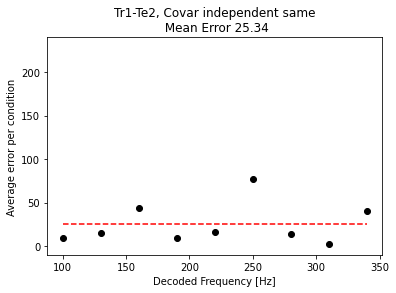

In [15]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_A_Tr1-Te2_covar_ind_same.jpg')


vec_mean_errors_covar_same[0] = np.mean(error_Hz_vec)

## Repeat the same procedure (train, decode, shuffle) for for the other fold. Store the data.

### Training the model on the other fold of that condition.

Now,

condition_matrix -> test_matrix

matrix -> train_matrix

In [16]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.08780346722473466
--- 13.326063871383667 seconds ---


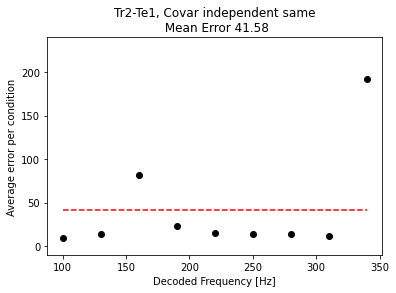

In [17]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_A_Tr2-Te1_covar_ind_same.jpg')

vec_mean_errors_covar_same[1] = np.mean(error_Hz_vec)

# `likelihoods_covar_independent_different`

In [18]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.08780346722473464
max residual variance 1.5345472265184439
min residual variance 0.004822537489061735
--- 15.865470170974731 seconds ---


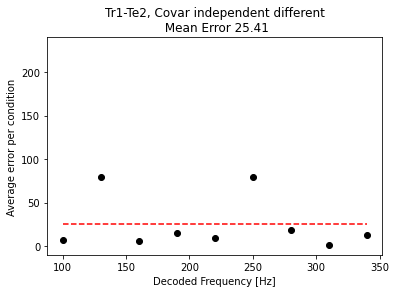

In [19]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_A_Tr1-Te2_covar_ind_diff.jpg')

vec_mean_errors_covar_different[0] = np.mean(error_Hz_vec)

In [20]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.08780346722473466
max residual variance 1.5345472265184439
min residual variance 0.004822537489061719
--- 23.009419918060303 seconds ---


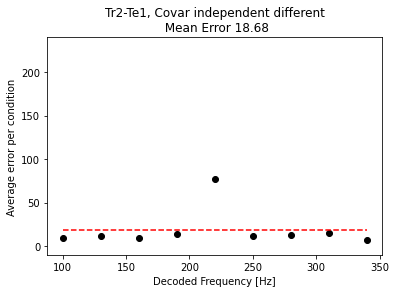

In [21]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_A_Tr2-Te1_covar_ind_diff.jpg')

vec_mean_errors_covar_different[1] = np.mean(error_Hz_vec)

# Include here the other conditions!
### Condition B

In [22]:
condition = "B"
train_matrix = B1[mask_all] # condition_matrix
test_matrix = B2[mask_all] # matrix

# `likelihoods_covar_independent_same`

In [23]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.09362394617147314
--- 16.309253931045532 seconds ---


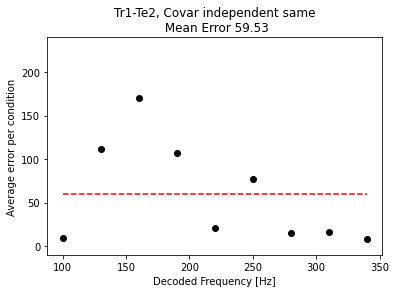

In [24]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_B_Tr1-Te2_covar_ind_same.jpg')

vec_mean_errors_covar_same[2] = np.mean(error_Hz_vec)

## Repeat the same procedure (train, decode, shuffle) for for the other fold. Store the data.

### Training the model on the other fold of that condition.

Now,

condition_matrix -> test_matrix

matrix -> train_matrix

In [25]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.09362394617147315
--- 12.357905864715576 seconds ---


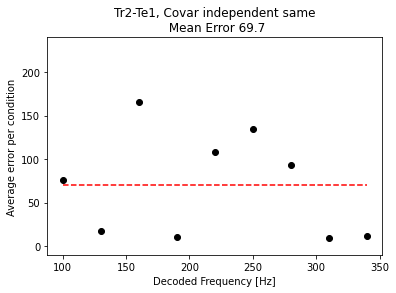

In [26]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_B_Tr2-Te1_covar_ind_same.jpg')

vec_mean_errors_covar_same[3] = np.mean(error_Hz_vec)

# `likelihoods_covar_independent_different`

In [27]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.09362394617147314
max residual variance 1.4954140366655537
min residual variance 0.00843352726254321
--- 13.263978958129883 seconds ---


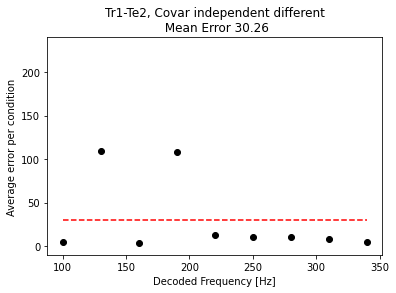

In [28]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_B_Tr1-Te2_covar_ind_diff.jpg')

vec_mean_errors_covar_different[2] = np.mean(error_Hz_vec)

In [29]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.09362394617147315
max residual variance 1.4954140366655535
min residual variance 0.008433527262543199
--- 17.399037837982178 seconds ---


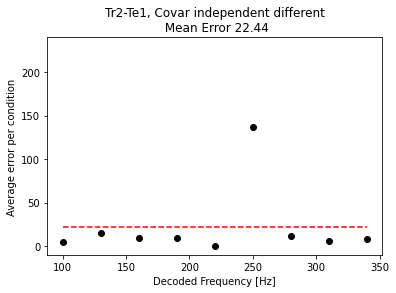

In [30]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_B_Tr2-Te1_covar_ind_diff.jpg')

vec_mean_errors_covar_different[3] = np.mean(error_Hz_vec)

### Condition C

In [31]:
condition = "C"
train_matrix = C1[mask_all] # condition_matrix
test_matrix = C2[mask_all] # matrix

# `likelihoods_covar_independent_same`

In [32]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.11138541614286553
--- 15.2375648021698 seconds ---


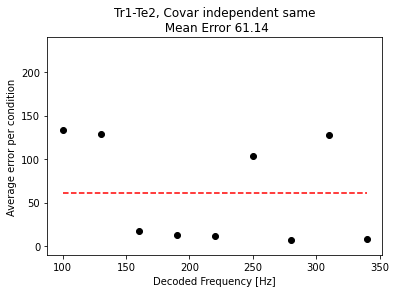

In [33]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_C_Tr1-Te2_covar_ind_same.jpg')

vec_mean_errors_covar_same[4] = np.mean(error_Hz_vec)

## Repeat the same procedure (train, decode, shuffle) for for the other fold. Store the data.

### Training the model on the other fold of that condition.

Now,

condition_matrix -> test_matrix

matrix -> train_matrix

In [34]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.1113854161428655
--- 19.156771183013916 seconds ---


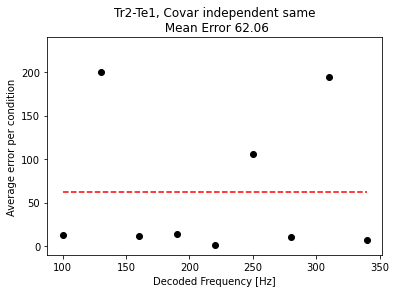

In [35]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_C_Tr2-Te1_covar_ind_same.jpg')

vec_mean_errors_covar_same[5] = np.mean(error_Hz_vec)

# `likelihoods_covar_independent_different`

In [36]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.11138541614286553
max residual variance 1.5210005633229864
min residual variance 0.007164728213555562
--- 16.62579107284546 seconds ---


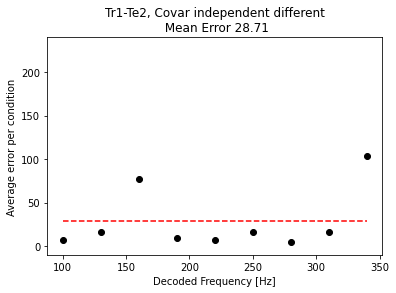

In [37]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_C_Tr1-Te2_covar_ind_diff.jpg')

vec_mean_errors_covar_different[4] = np.mean(error_Hz_vec)

In [38]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.1113854161428655
max residual variance 1.521000563322988
min residual variance 0.0071647282135555435
--- 17.714540004730225 seconds ---


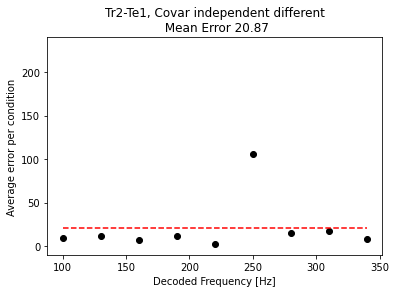

In [39]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_C_Tr2-Te1_covar_ind_diff.jpg')

vec_mean_errors_covar_different[5] = np.mean(error_Hz_vec)

### Condition D

In [40]:
condition = "D"
train_matrix = D1[mask_all] # condition_matrix
test_matrix = D2[mask_all] # matrix

# `likelihoods_covar_independent_same`

In [41]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.110331899410513
--- 15.985491752624512 seconds ---


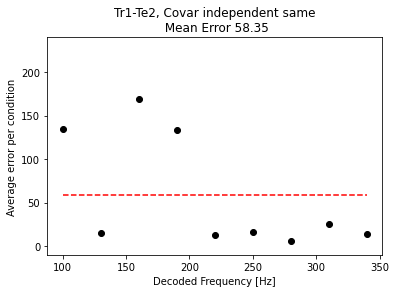

In [42]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_D_Tr1-Te2_covar_ind_same.jpg')

vec_mean_errors_covar_same[6] = np.mean(error_Hz_vec)

## Repeat the same procedure (train, decode, shuffle) for for the other fold. Store the data.

### Training the model on the other fold of that condition.

Now,

condition_matrix -> test_matrix

matrix -> train_matrix

In [43]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_same)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
Covar independent, same values
 Residual variance 0.110331899410513
--- 13.021981954574585 seconds ---


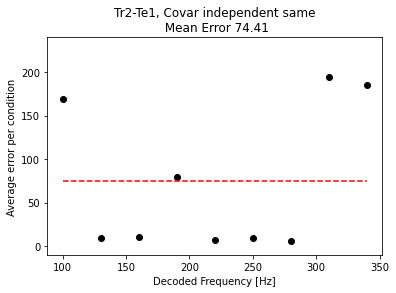

In [44]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent same\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_D_Tr2-Te1_covar_ind_same.jpg')

vec_mean_errors_covar_same[7] = np.mean(error_Hz_vec)

# `likelihoods_covar_independent_different`

In [45]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = train_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This last function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.110331899410513
max residual variance 2.950786738881778
min residual variance 0.007802728858098755
--- 11.571478128433228 seconds ---


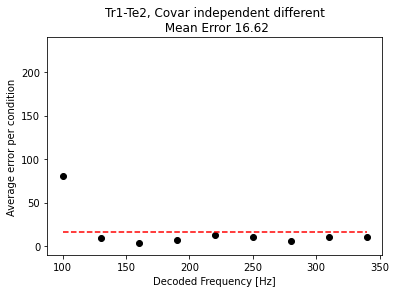

In [46]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr1-Te2, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_D_Tr1-Te2_covar_ind_diff.jpg')

vec_mean_errors_covar_different[6] = np.mean(error_Hz_vec)

In [47]:
# Modified cell for use in real data from cell above called: Creating simulated data
# Initializing variables
nStimuli = 9
# nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix
# nNeurons = 120
# sigma = 10
# nVoxels = 500 # train_matrix.shape[0] # number of voxels
# noiseStandardDeviation = 0.35 # 0.4

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7
nfrequencies = 241
initial_frequency = 100

# stimuli, frequency_range, B, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons, sigma,
#                                                             nVoxels, noiseStandardDeviation)

# Dude. The detail was that // was performing a floor division operator.
# X1 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 0] for k in range(B.shape[1])]).T
# X2 = np.array([ [B[i][k] for i in range(B.shape[0]) if i % 2 == 1] for k in range(B.shape[1])]).T

B_train = test_matrix.T # B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = train_matrix.T # B_test = test_matrix.T # testVoxelResponse (B2) [txv]
nVoxels = B_train.shape[1]
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = analysis(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency, likelihoods_covar_independent_different)
# This analysis function is what I modified, where the information for the covariance matrix is.
B = np.asarray([elem for pair in zip(B_train, B_test) for elem in pair]) # Code suggested by ChatGPT on Nov 27

nVoxels 341
Data ready.
Model fit ready.
(341,)
Covar independent, different values
  Residual variance 0.110331899410513
max residual variance 2.950786738881779
min residual variance 0.007802728858098769
--- 14.865226030349731 seconds ---


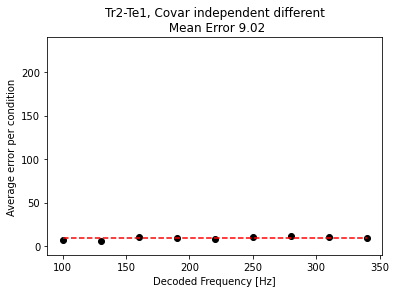

In [48]:
# Voxel response
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, error_Hz_vec)

# Calculating the error of the fitted gaussian's mean compared to the real frequency.
plt.scatter(tactile_stimuli, error_Hz_vec, c="k")#, label=label_Hz)
plt.hlines(np.mean(error_Hz_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
           linestyle='dashed', colors = 'r')
plt.ylim([-10,240])
plt.xlabel(r'Decoded Frequency [Hz]')
plt.ylabel(r'Average error per condition')    
plt.title("Tr2-Te1, Covar independent different\n Mean Error "+str(np.round(np.mean(error_Hz_vec), 2)))
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_D_Tr2-Te1_covar_ind_diff.jpg')

vec_mean_errors_covar_different[7] = np.mean(error_Hz_vec)

# Include here a graph of:
`vec_mean_errors_covar_same` and `vec_mean_errors_covar_different`

These vectors have 8 entries.

In [49]:
xx = [i for i in range(8)]

In [50]:
vec_mean_errors_covar_different

array([25.41040237, 18.67778745, 30.26456361, 22.4353366 , 28.70598574,
       20.87470931, 16.62450797,  9.02253039])

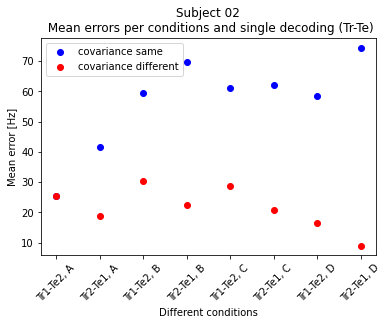

In [53]:
xlabels = ["Tr1-Te2, A", "Tr2-Te1, A", "Tr1-Te2, B", "Tr2-Te1, B",
           "Tr1-Te2, C", "Tr2-Te1, C", "Tr1-Te2, D", "Tr2-Te1, D"]
plt.xticks(xx, xlabels, rotation=45)
plt.scatter(xx, vec_mean_errors_covar_same, c='b', label="covariance same")
plt.scatter(xx, vec_mean_errors_covar_different, c='r', label="covariance different")
plt.title('Subject '+subject_number+'\n Mean errors per conditions and single decoding (Tr-Te)')
plt.xlabel('Different conditions')
plt.ylabel('Mean error [Hz]')
plt.legend()
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_mean_errors.jpg')

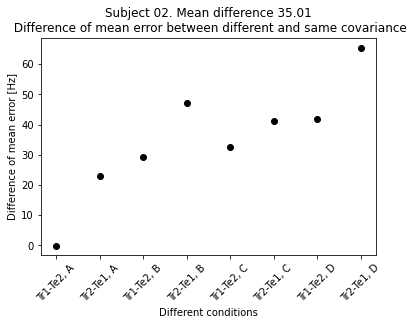

In [52]:
# Quantify the previous plot.
difference = vec_mean_errors_covar_same-vec_mean_errors_covar_different

xlabels = ["Tr1-Te2, A", "Tr2-Te1, A", "Tr1-Te2, B", "Tr2-Te1, B",
           "Tr1-Te2, C", "Tr2-Te1, C", "Tr1-Te2, D", "Tr2-Te1, D"]

plt.xticks(xx, xlabels, rotation=45)
plt.scatter(xx, difference, c='k')

plt.title('Subject '+subject_number+'. Mean difference '+str(np.round(np.mean(difference),2))+ '\n Difference of mean error between different and same covariance')
plt.xlabel('Different conditions')
plt.ylabel('Difference of mean error [Hz]')
# plt.show()
plt.savefig('Graphs/covariance/S'+subject_number+'_mean_difference.jpg')